# Práctica 2: Introducción a PyTorch

In [2]:
# Importamos todas las librerias: 
# Activate ext autoreload 
%load_ext autoreload
%autoreload 2

import os 
import torch
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from utils.trainer_graphs import trainer, graficos
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print('Is GPU available?', torch.cuda.is_available())
print('Model of the GPU:', torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Is GPU available? True
Model of the GPU: NVIDIA GeForce RTX 2060


## a) Calculando el gradiente mediante Autograd

En primer lugar, vamos a calcular del gradiente para el perceptrón simple con función de activación sigmoidea que vimos en la teoría. Pero esta vez, en lugar de realizar manualmente el proceso de backpropagation, vamos a usar el módulo `autograd` de PyTorch.

La función $f(x, w)$ a la cual queremos encontrarle el gradiente es:

> $f(\mathbf{x}, \mathbf{w}) = \frac{1}{1 + e^{2-(w_0 x_0 + w_1 x_1 + w_2)}}$

Definimos entonces la función utilizando `torch.tensor` (recordar usar el parámetro `requires_grad = True` para que PyTorch guarde los gradientes) y realizamos la pasada "forward" para los siguientes valores de x y w:

> $\mathbf{x} = (-1, -2)$

> $\mathbf{w} = (2, -3, -3)$



In [2]:
x = torch.tensor([-1.0,-2.0],requires_grad = True,device = device)
w = torch.tensor([2.0,-3.0,-3.0],requires_grad = True,device = device)

def f(x,w):
    x0,x1 = x 
    w0,w1,w2 = w 
    z = 2-(w0*x0+w1*x1+w2)
    return 1/(1 + torch.exp(z))
y = f(x,w).to(device)

Ahora, utilizando la función `f.backward()` computamos los gradientes $\frac{\partial f}{ \partial \mathbf{x}}$ y $\frac{\partial f}{ \partial \mathbf{w}}$

In [3]:
y.backward()
print("Gradiente df/dx = " + str(x.grad))
print("Gradiente df/dw = " + str(w.grad))

Gradiente df/dx = tensor([ 0.3932, -0.5898], device='cuda:0')
Gradiente df/dw = tensor([-0.1966, -0.3932,  0.1966], device='cuda:0')


## b) Minimizando una función con Gradient Descent

Ahora, vamos a implementar usar el algorítmo de gradiente descendiente (utilizando Autograd para computar el gradiente) para minimizar la función cuadrática $$f(x) = 2x^2 + x + 4$$

Utilizaremos la implementación `torch.optim.SGD` de gradiente descendiente.



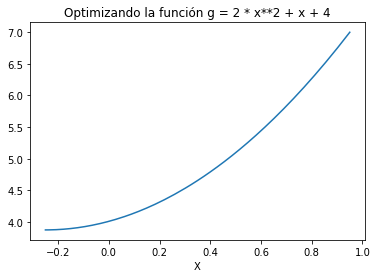

In [4]:
def g(x): 
    return 2*x**2 + x +4
# Definir la variable que será el parámetro a optimizar
x = torch.tensor([1.0],requires_grad=True,device=device)
# Definir el optimizador, indicando el parámetro a optimizar y el learning rate
optimizer = torch.optim.SGD(params=[x],lr=1e-2)
# Acumuladores que usaremos para guardar los valores sucesivos de x, y
g_values = []
x_values = []
# Loop de optimización
for i in range(1000):
    # Setemos en 0 los gradientes de todos los elementos
    optimizer.zero_grad()
    # Pasada forward: ejecutar la función a minimizar
    y = g(x)
    #print("X = " + str(x) + ", g(x) = " + str(g))
    # Pasada backward: computar los gradientes
    y.backward()
    # Actualizar los pesos dando un paso de gradiente descendiente
    optimizer.step()
    # Guardar los valores para luego plotearlos
    g_values.append(y.data.item())
    x_values.append(x.data.item())
# Ploteo los valores
plt.title("Optimizando la función g = 2 * x**2 + x + 4")
plt.xlabel("X")
plt.plot(x_values,g_values)

# c) Implementando un MLP en PyTorch para predicción del procentaje de grasa corporal

Contamos con una base de datos [1] de 252 mediciones del porcentaje de grasa corporal de 252 personas diferentes, el cual puede ser estimado mediante otras características, como la edad, el peso, y mediciones en diferentes partes del cuerpo. A partir de estos datos se pretende desarrollar un sistema que permita predecir dicho porcentaje a partir de las características.

[1]: Olson, R.S., La Cava, W., Orzechowski, P. et al. PMLB: a large benchmark suite for machine learning evaluation and comparison. BioData Mining 10, 36 (2017). https://epistasislab.github.io/pmlb/profile/560_bodyfat.html

Antes de comenzar, vamos a instalar el paquete de Python que contiene la base de datos:

In [5]:
#pip install pmlb

Ahora vamos a generar un histograma de todas las mediciones del porcentaje con todos los datos disponibles:

Fila de ejemplo:
['Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'target']
[  1.0708  23.     154.25    67.75    36.2     93.1     85.2     94.5
  59.      37.3     21.9     32.      27.4     17.1   ]


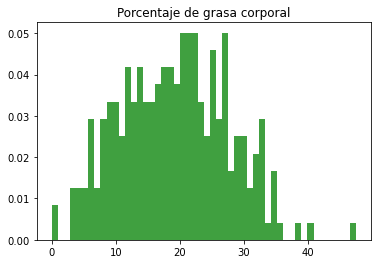

In [3]:
from pmlb import fetch_data
seed = 42 
# Importamos el dataset
body_fat = fetch_data('560_bodyfat')
body_fat.describe()

# Extraigo los datos (features) y los porcentajes (etiquetas a predecir)
data = body_fat.loc[:, body_fat.columns != 'target'].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == 'target'].to_numpy()

data = data.astype(np.float32)
percentages = percentages.astype(np.float32)

print("Fila de ejemplo:")
print(list(body_fat.columns))
print(data[0,:])

# Dibujo un histograma del porcentaje de grasa corporal usando todos los datos
_ = plt.hist( percentages , 50, density=True, facecolor='g', alpha=0.75)
_ = plt.title("Porcentaje de grasa corporal")

Particionamos los datos en entrenamiento y prueba usando la función `sklearn.model_selection.train_test_split`

In [4]:
# Particiono los datos en entrenamiento y prueba usando el método de scikitlearn
X_train, X_test, y_train, y_test = train_test_split(data,percentages,test_size=0.33,
                                                    random_state=seed)

Ahora implementaremos en PyTorch un Perceptrón multicapa que usaremos como regresor del porcentaje de grasa corporal (ejemplo basado en el curso de [RPI](https://rpi.analyticsdojo.com/)).

El perceptrón deberá contar con 3 capas:
- Las dos primeras con 200 neuronas, y deberán usar la función de activación ReLU.
- La última con una única neurona cuya salida sea un valor escalar que corresponda al porcentaje de grasa corporal estimado de la persona, que no deberá utilizar ninguna función de activación.

Algunas clases de PyTorch que resultarán útiles para implementar el modelo, son:
- `torch.nn.Linear`: Implementa una capa totalmente conectada. Es necesario especificarle el número de parámetros de entrada y de salida.
- `torch.nn.functional.relu`: Implementa la función de activación ReLU.

Además, utilizaremos el optimizador `torch.optim.Adam` y la función de pérdida `torch.nn.MSELoss` (error cuadrático medio).






In [5]:
class Net(nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_features,size_hidden)
        self.hidden2 = nn.Linear(size_hidden,size_hidden)
        self.out = nn.Linear(size_hidden,n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        output = self.out(x)
        return output

Current device is cuda:0
Epoch 1000, loss = 77.311
Epoch 2000, loss = 77.3072
Epoch 3000, loss = 77.3085
Epoch 4000, loss = 77.3065
3.7937536239624023
Current device is cuda:0
MSE medio en training: 77.3057
MSE medio en test: 54.77953
Current device is cuda:0
Epoch 1000, loss = 19.3075
Epoch 2000, loss = 18.219
Epoch 3000, loss = 16.3372
Epoch 4000, loss = 16.6462
0.7552170753479004
Current device is cuda:0
MSE medio en training: 15.332476
MSE medio en test: 18.202175
Current device is cuda:0
Epoch 1000, loss = 10.5481
Epoch 2000, loss = 2.02911
Epoch 3000, loss = 1.70943
Epoch 4000, loss = 0.886732
0.006752536632120609
Current device is cuda:0
MSE medio en training: 2.053655
MSE medio en test: 34.30356


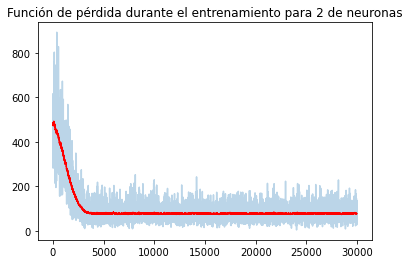

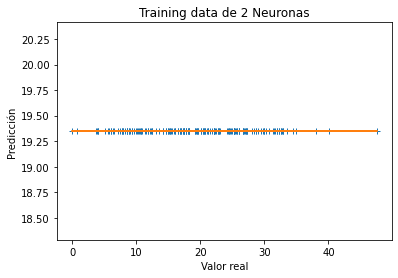

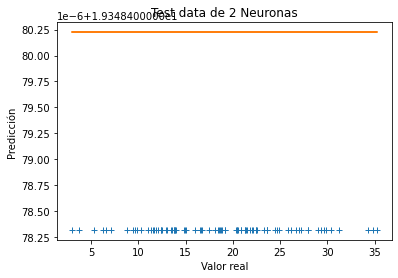

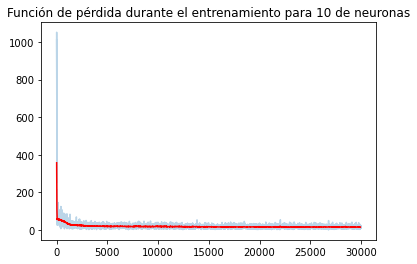

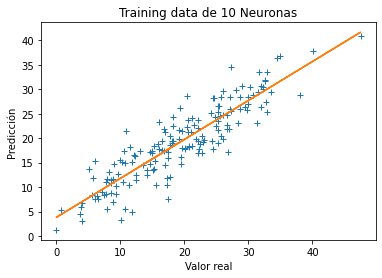

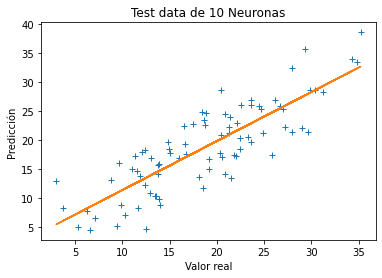

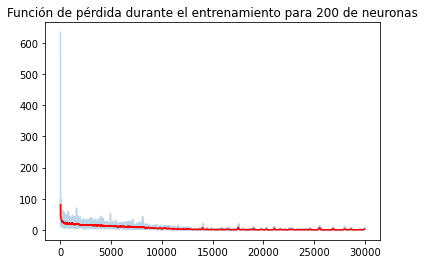

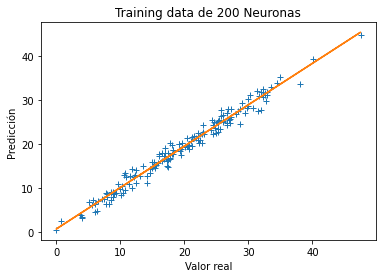

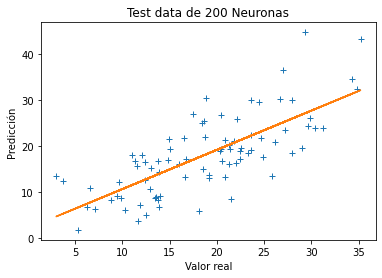

In [10]:
args={'num_epochs':5000,'learning_rate':1e-3,'batch_size':32,'X_train':X_train,'y_train':y_train}
X,y=[X_train,X_test],[y_train,y_test]
criterion = nn.MSELoss()
for Neuronas in [2,10,200]:
    args['Neuronas'] = Neuronas
    net = Net(14,Neuronas,1)
    trainer(net,criterion,args)
    graficos(net,X,y,Neuronas)

# Entregable
1. Encontrar el mínimo de la función *f* definida en el apartado b). Para ello, deberán encontrar primero la derivada *f'(x)* de forma analítica, y utilizarla para computar el mínimo de la función. Posteriormente, deberán corrobarar que el valor coincida con el que obtuvieron optimizando la función con gradiente descendiente.

2. Compara el rendimiento de 3 perceptrones multicapa que varíen en la cantidad de neuronas en sus capas intermedia. Probar colocando 2, 10 y 200 neuronas en dichas capas, al entrenar los perceptrones durante 5000 épocas. Mostrar los resultados utilizando:

* los gráficos de dispersión con la recta de regresión
* el error medio en los datos de entrenamiento y test

  Analizar la relación entre dichos resultados y la cantidad de neuronas que posee el perceptrón.


1.
Encontramos el minimo de la funcion de forma analitica:
$$ f'(x)= 4x + 1 =^{?}0 $$ luego
$$ x = -\frac{1}{4} $$
Vemos que es el minimo, pues es una funcion cuadratica con coeficiente principal positivo, que es lo que nos termino dando cuando minimizamos la funcion con gradiente descendiente.

2.
El modelo que fue entrenado con 10 neuronas aparentemente funciona mejor que los otros dos, pues presentó un MSE medio más bajo para test, y puede ser indicio de que tiene una capacidad de generalización mayor, aún que el modelo con 200 neuronas haya presentado un valor más bajo en el dataset de entrenamiento, esto indica un sobreajuste, siendo un modelo muy complejo para este problema.

Por otro lado el modelo más simple, presenta un subajuste pues pareciera ser un modelo muy simple para el problema presentado.